In [109]:
import numpy as np
import cv2
import sklearn
import scipy
import imageio
import math
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize_scalar, root_scalar
import glob

In [110]:
def extract_num(fp):
    return int(fp.split('.')[0].split(' ')[1])

In [111]:
# find the offsets for the horizontal images
def get_phase_correlations(images):
    offsets = []
    for i in range(len(images)-1):
        d = cv2.phaseCorrelate(images[i], images[i+1])
        offsets.append(d)
    return offsets

In [112]:
def combine_images(image1, image2, offset_x, offset_y):
    offset_x = -int(offset_x)
    offset_y = int(offset_y)
    if offset_x < 0:
        merge_width = max(image2.shape[1], image1.shape[1]-offset_x)
        warp_offset_x = 0
        ref_offset_x = offset_x
    else:
        merge_width = max(image2.shape[1] + offset_x, image1.shape[1])
        warp_offset_x = offset_x
        ref_offset_x = 0
    if offset_y < 0:
        merge_height = max(image2.shape[0], image1.shape[0]-offset_y)
        warp_offset_y = 0
        ref_offset_y = offset_y
    else:
        merge_height = max(image2.shape[0] + offset_y, image1.shape[0])
        warp_offset_y = offset_y
        ref_offset_y = 0
    
    combined_image = np.zeros((merge_height,merge_width,3)).astype(np.uint8)
    for y in range(image2.shape[0]):
        for x in range(image2.shape[1]):
            combined_image[y+warp_offset_y,x+warp_offset_x] = image2[y,x]
    
    for y in range(image1.shape[0]):
        for x in range(image1.shape[1]):
            if np.all((combined_image[y-ref_offset_y,x-ref_offset_x] == 0)):
                combined_image[y-ref_offset_y, x-ref_offset_x] = image1[y,x]
    return combined_image

In [113]:
# calculate f: 2pi - 2 * sum(atan(d_i /f)) = 0
def compute_f(widths):
    widths = np.asarray(widths)
    def cost(f):
        goal = 2*np.pi
        val = 2*np.arctan(widths / f).sum()
        return val - goal

    def costprime(f):
        # derivative of cost
        return (widths / (widths ** 2 + f ** 2)).sum()
    
    res = root_scalar(cost, bracket=(250, 750), fprime=costprime)
    return(res.root)

In [114]:
def horizontalAngle(horizontal_shifts, focal_length):
    thetas = [None * len(horizontal_shifts)]
    thetas[0] = 0 
    for i in range(1, len(horizontal_shifts)):
        thetas[i] = thetas[i-1] + 2*np.arctan(thetas[i] / (2*f))
    return thetas

In [115]:
def verticalAngle(vertical_shifts, focal_length):
    gammas = [None * len(vertical_shifts)]
    gammas[0] = 0 
    for i in range(1, len(horizontal_shifts)):
        thetas[i] = thetas[i-1] + 2*np.arctan(thetas[i] / (2*f))
    return thetas

In [116]:
# read in the images
row0_files = sorted(glob.glob("test_data_6/0*"), key=extract_num)
row1_files = sorted(glob.glob("test_data_6/1*"), key=extract_num)

# row0 is horizontal, and row1 is above the horizontal 
row0, row1 = [cv2.imread(i) for i in row0_files], [cv2.imread(i) for i in row1_files]

image_matrix = [row1, row0]

In [117]:
# Compute Phase Correlations
phase_corr_rows = [[[0,0] for y in x] for x in image_matrix]
for r_i in range(len(image_matrix)):
    for c_i in range(len(image_matrix[r_i]) - 1):
        curr_corr = cv2.phaseCorrelate(rgb2gray(image_matrix[r_i][c_i]), rgb2gray(image_matrix[r_i][c_i+1]))
        phase_corr_rows[r_i][c_i+1] = [curr_corr[0][0], curr_corr[0][1]]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


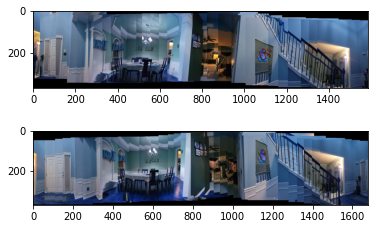

In [118]:
# Simple Combine Images
simple_combine_rows = [] 
for r_i in range(len(image_matrix)):
    combined_image = None
    offset_x = 0
    offset_y = 0
    for c_i in range(len(image_matrix[r_i]) - 1):
        if combined_image is None:
            combined_image = image_matrix[r_i][c_i]
        else:
            offset_x += phase_corr_rows[r_i][c_i][0]
            offset_y += phase_corr_rows[r_i][c_i][1] 
            combined_image = combine_images(combined_image, image_matrix[r_i][c_i+1], offset_x, offset_y)
    simple_combine_rows.append(combined_image)

fig,axes = plt.subplots(len(image_matrix), 1)
for im_i in range(len(simple_combine_rows)):
    axes[im_i].imshow(simple_combine_rows[im_i])
    
plt.show()

In [119]:
# Focal Lengths
focal_lengths = []
all_widths = [[-y[0] for y in x if y is not None] for x in phase_corr_rows]
for row in all_widths:
    focal_lengths.append(compute_f(row))
focal_len = sum(focal_lengths)/len(focal_lengths)

In [132]:
# Compute Horizontal Angles (theta, phi)
image_angles = [[[0,0] for y in x] for x in image_matrix]
for r_i in range(len(image_matrix)):
    for c_i in range(len(image_matrix[r_i]) - 1):
        image_angles[r_i][c_i+1][0] = image_angles[r_i][c_i][0] + 2*np.arctan(-phase_corr_rows[r_i][c_i+1][0] / (2*focal_len))


In [163]:
def compute_transformation_matrix(f, theta, phi): 
    r0 = [[1,0,0],[1,np.cos(phi), -np.sin(phi)],[0,np.sin(phi), np.cos(phi)]]
    r1 = [[np.cos(theta), 0, np.sin(theta)], [0,1,0], [-np.sin(theta), 0, np.cos(theta)]]
    r = np.matmul(np.asarray(r0), np.asarray(r1))
    v = [[f, 0, 0],[0,f,0],[0,0,1]]
    
    tran_mat = np.matmul(v, r) 
    tran_mat = np.linalg.inv(tran_mat)
    return tran_mat

In [165]:
img_trans_mat = [[None for y in x] for x in image_matrix]
for r_i in range(len(image_matrix)):
    for c_i in range(len(image_matrix[r_i])):
        img_trans_mat[r_i][c_i] = compute_transformation_matrix(focal_len, image_angles[r_i][c_i][0],image_angles[r_i][c_i][1])

In [171]:
transformed_images = {}
for r_i in range(len(image_matrix)-1):
    for c_i in range(len(image_matrix[r_i])):
        curr = image_matrix[r_i][c_i]
        for pr_i in range(len(curr)):
            for cr_i in range(len(curr[pr_i])):
                out = np.matmul(img_trans_mat[r_i][c_i], np.asarray([pr_i,cr_i,0]))
                # IDK WHERE TO GO FROM HERE
"""
It seems like the transformation matrices are outputting transformed matrices that
are not correct. They range in the 0.0-1.0 values for x,y,z. Help
"""       